## Hyperparam

In [ ]:
block_size = 170
# max_len = 20
batch_size = 128
n_layer = 8 
n_head = 8 
n_embd = 128
max_epochs = 2

stop_token = '$'
split_token = '&'

## Import

In [2]:
# set up logging
import logging
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)

# from flattenV3Advanced import flattenData

# make deterministic
from minGPT.mingpt.utils import set_seed
set_seed(42)

import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
device = torch.cuda.current_device()
from torch.utils.data.dataloader import DataLoader
from torchvision import datasets, models, transforms


import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from datetime import datetime
import math
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
from torchtext.data.metrics import bleu_score

from minGPT.mingpt.model import GPT, GPTConfig
# from minGPT.mingpt.trainer import Trainer, TrainerConfig
# from minGPT.mingpt.utils import sample

from sklearn.metrics import mean_squared_error

from tqdm import tqdm
import random
import pandas as pd
import string
import re
import os
import time

import logging

logger = logging.getLogger(__name__)

from rdkit.Chem.rdMolDescriptors import CalcMolFormula
from rdkit.Chem import AllChem, Descriptors
from rdkit import Chem
from rdkit.rdBase import BlockLogs
from rdkit.Chem import PandasTools
block = BlockLogs() ## not sure we want to block all but rdkit complain when wrong smiles are sent...

## dataset path
data_path = '/home/teleport/perso/2pc_cleaned.csv'
EXPERIMENT = '20201210_DF_gpt_smiles'
experiment_path = "/opt/data/train_dir/" + EXPERIMENT + "/"
if not os.path.exists(experiment_path):
    os.mkdir(experiment_path)

%matplotlib inline

12/11/2020 11:01:13 - INFO - rdkit -   Enabling RDKit 2020.09.1 jupyter extensions


## Trains and tensorboard

In [3]:
now = datetime.now()
writer = SummaryWriter(experiment_path + '/' + now.strftime("%Y%m%d-%H%M%S") + "/")
from trains import Task
import trains
task = Task.init(project_name='gpt_smiles', task_name=EXPERIMENT)

TRAINS Task: overwriting (reusing) task id=b14bc564c3e44b849bfe82e73134c965
TRAINS results page: http://172.22.4.157:8080/projects/8f2ac9400a46477683280746b293e09f/experiments/b14bc564c3e44b849bfe82e73134c965/output/log


## Dataset

In [4]:
data = pd.read_csv(data_path)
data.columns

2020-12-11 11:01:14,779 - trains.Repository Detection - WARNING - Can't get branch information for git repo in /home/teleport/.conda/envs/pytorch_smiles/lib/python3.8/site-packages
2020-12-11 11:01:14,789 - trains.Repository Detection - WARNING - Can't get commit information for git repo in /home/teleport/.conda/envs/pytorch_smiles/lib/python3.8/site-packages
2020-12-11 11:01:14,798 - trains.Repository Detection - WARNING - Can't get root information for git repo in /home/teleport/.conda/envs/pytorch_smiles/lib/python3.8/site-packages
2020-12-11 11:01:14,833 - trains.Repository Detection - WARNING - Can't get status information for git repo in /home/teleport/.conda/envs/pytorch_smiles/lib/python3.8/site-packages
2020-12-11 11:01:14,851 - trains.Repository Detection - WARNING - Can't get diff information for git repo in /home/teleport/.conda/envs/pytorch_smiles/lib/python3.8/site-packages
2020-12-11 11:01:14,861 - trains.Repository Detection - WARNING - Can't get modified information fo

Index(['smiles', 'mwt', 'logp', 'n_atoms', 'MolFormula', 'l', 'CHNO',
       'l_MolFormula', 'l_chunk', 'train'],
      dtype='object')

In [5]:
data_train = data[data['train'] == True].reset_index()
data_test = data[data['train'] == False].reset_index()
print(len(data))
print(len(data_train))
print(len(data_test))

8659463
8605866
53597


## word list

In [6]:
word_list = ['C','c','N','n','O','o','H','B','r','l','I','F','S','s','P','.','[',']','(',')','-','+','=','@','/','\\','#','$','&']
word_list += list(string.digits)
stoi = { ch:i for i,ch in enumerate(word_list) }
itos = { i:ch for i,ch in enumerate(word_list) }

## Helper functions for checking the smiles and tokenize them, detokenize them

In [7]:
def tokenize_idx(data, idx, stoi, block_size = None, stop_token = '$', split_token = '&'):
    return tokenize_smiles(data['smiles'][idx],data['MolFormula'][idx],data['logp'][idx], stoi, block_size=block_size, stop_token = '$', split_token = '&')

def tokenize_smiles(smiles, molecular_formula, logp, stoi, block_size = None, stop_token = '$', split_token = '&'):
    chunk = str(round(logp,1)) + split_token + molecular_formula + split_token + smiles + stop_token
    if block_size is not None:
        chunk = chunk + stop_token*(block_size - len(chunk))
    data = [stoi[s] for s in chunk]
    return data

def y_to_completion(y, itos):
    return ''.join([itos[int(i)] for i in y])
    

# def check_completion(completion, stop_token = '$', split_token = '&'):
#     '''
#     return a string with the status of the check:
#     full_failure: cannot process it at all
#     smiles_failure: MolFromSmiles return None
#     MolFormula_failure: CalcMolFormula from the smile is different
#     success: CalcMolFormula from the smile is same
#     '''
    
#     try:
#         completion = completion.split(split_token)
#         logp = completion[0]
#         MolFormula = completion[1]
#         smiles = completion[2].split(stop_token)[0]
#         mol = Chem.MolFromSmiles(smiles)
#         if mol is None:
#             return 'smiles_failure'
#         MolFormula_smiles = CalcMolFormula(mol)
#         logp_smiles = Descriptors.MolLogP(mol)
#         if MolFormula != MolFormula_smiles:
#             return 'MolFormula_failure'
#         return 'success'
#     except:
#         return 'full_failure'

    
def check_model_output(model, MolFormulas, logps, stop_token = '$', split_token = '&', batch_size = 4,temperature=0.9):
    completions = []
    for i, j  in zip(MolFormulas, logps):        
        data = [stoi[s] for s in str(round(j,1)) + split_token + i + split_token]
        x = [torch.tensor(data, dtype=torch.long).unsqueeze(0).to(device)]
        y = sample_clean(model, x, steps = block_size, temperature=temperature, sample=True, top_k=5, itos = itos, stop_token = '$', batch_size = batch_size)
        for idx in range(y.size(0)):    
            completion = y_to_completion(y[idx], itos)
            completions.append(completion)
    df = completion_to_pandas(completions)
            
    return df, completions
    
def completion_to_pandas(completion):
    smiles = []
    MolFormulaInput = []
    MolFormulaOutput = []
    logpInput = []
    logpOutput = []
    for i in completion:
#         print(i)
        i = i.split(split_token)
        logpInput.append(i[0])
        MolFormulaInput.append(i[1])
        smile = i[2].split(stop_token)[0]
        smiles.append(smile)
        mol = Chem.MolFromSmiles(smile)
        if mol is None:
            MolFormulaOutput.append('fail')
            logpOutput.append('fail')
        else:
            MolFormulaOutput.append(CalcMolFormula(mol))
            logpOutput.append(Descriptors.MolLogP(mol))
    df = pd.DataFrame(list(zip(logpInput,MolFormulaInput, smiles,logpOutput, MolFormulaOutput)), 
               columns =['logpInput','MolFormulaInput', 'smiles', 'logpOutput', 'MolFormulaOutput']) 
    PandasTools.AddMoleculeColumnToFrame(df,smilesCol='smiles')
    return(df)

def check_df(df):
    df2 = df[df['MolFormulaOutput'] != 'fail']
    smiles_failure_ratio = (len(df) - len(df2))/len(df)
    MolFormula_success = sum(df2['MolFormulaInput'] == df2['MolFormulaOutput'])/len(df)
    MolFormula_failure = sum(df2['MolFormulaInput'] != df2['MolFormulaOutput'])/len(df)
    logp_mse = mean_squared_error(df2['logpInput'],df2['logpOutput'])
    return {'smiles_failure_ratio':smiles_failure_ratio, 
            'MolFormula_failure':MolFormula_failure,
           'MolFormula_success':MolFormula_success,
           'logp_mse':logp_mse}


def add_mol(writer, smiles, global_step=None, size=(300, 300)):
    """
    Adds a molecule to the images section of Tensorboard.
    """
    img_transform = transforms.Compose([
            transforms.ToTensor()
        ])
    mol = Chem.MolFromSmiles(smiles)
    image = Chem.Draw.MolToImage(mol, size=size)
    writer.add_image(smiles, img_transform(image), global_step) 
    

In [8]:
y = tokenize_idx(data_test, 0, stoi)
completion = y_to_completion(y, itos)
completion

check_df(completion_to_pandas([completion]))

{'smiles_failure_ratio': 0.0,
 'MolFormula_failure': 0.0,
 'MolFormula_success': 1.0,
 'logp_mse': 0.002550249999999954}

In [9]:
completion = '1.2&C23H39N5O&CN(C)c1ccc(CNC(=O)CN2CCC(C)(CN3CCN(C)CC3)CC2)cc1'
check_df(completion_to_pandas([completion]))

{'smiles_failure_ratio': 0.0,
 'MolFormula_failure': 0.0,
 'MolFormula_success': 1.0,
 'logp_mse': 0.26863489000000185}

## Dataloader

In [10]:
class SmilesDataset(Dataset):

    def __init__(self, data, block_size, stoi, itos):
        
        self.data = data
        self.stoi = stoi
        self.itos = itos
        self.block_size = block_size
        self.vocab_size = len(self.stoi)
        
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx,verbose=False):
        try:
            converted_chunk = tokenize_idx(self.data, idx, self.stoi, self.block_size)
        except:
            print('error in data loader: idx = ' + idx)
            return self.__getitem__(random.randint(0, len(self.data)))
        x = torch.tensor(converted_chunk[:-1], dtype=torch.long)
        y = torch.tensor(converted_chunk[1:], dtype=torch.long)
        return x, y
            
train_dataset = SmilesDataset(data_train, block_size, stoi, itos) 
test_dataset = SmilesDataset(data_test, block_size, stoi, itos) 

df = train_dataset.__getitem__(idx = 10,verbose=True)

## Model declaration

In [11]:
mconf = GPTConfig(train_dataset.vocab_size, train_dataset.block_size,
                  n_layer=n_layer, n_head=n_head, n_embd=n_embd)
model = GPT(mconf)
# model.load_state_dict(torch.load(experiment_path + 'model_0.pt'))

12/11/2020 11:01:23 - INFO - minGPT.mingpt.model -   number of parameters: 1.618176e+06


## Sample function

In [12]:
def top_k_logits(logits, k):
    v, ix = torch.topk(logits, k)
    out = logits.clone()
    out[out < v[:, [-1]]] = -float('Inf')
    return out

@torch.no_grad()
def sample_clean(model, xs, steps, temperature=1.0, sample=False, top_k=None, itos = None, stop_token = '$',batch_size = 4):
#     block_size = model.get_block_size()
    model.eval()
    xs = sorted(xs, key = lambda x: x.size(1))
    ## add the batch size
    xs = [torch.cat(batch_size*[x]) for x in xs]
    
    ## start by making them the same length
    x = xs[0]
    for i in range(1,len(xs)): # nothing to do if length 1
        while x.size(1) < xs[i].size(1):
            x_cond = x if x.size(1) <= block_size else x[:, -block_size:] # crop context if needed
            logits, _ = model(x_cond)
            # pluck the logits at the final step and scale by temperature
            logits = logits[:, -1, :] / temperature
            # optionally crop probabilities to only the top k options
            if top_k is not None:
                logits = top_k_logits(logits, top_k)
            # apply softmax to convert to probabilities
            probs = F.softmax(logits, dim=-1)
            # sample from the distribution or take the most likely
            if sample:
                ix = torch.multinomial(probs, num_samples=1)
            else:
                _, ix = torch.topk(probs, k=1, dim=-1)
            # append to the sequence and continue
            x = torch.cat((x, ix), dim=1)
        x= torch.cat((x,xs[i]), dim=0)
    
    
    ## now we can keep going...
    keep_going = True
    while keep_going:
#         print(x.size(1))
        x_cond = x if x.size(1) <= block_size else x[:, -block_size:] # crop context if needed
        logits, _ = model(x_cond)
        # pluck the logits at the final step and scale by temperature
        logits = logits[:, -1, :] / temperature
        # optionally crop probabilities to only the top k options
        if top_k is not None:
            logits = top_k_logits(logits, top_k)
        # apply softmax to convert to probabilities
        probs = F.softmax(logits, dim=-1)
        # sample from the distribution or take the most likely
        if sample:
            ix = torch.multinomial(probs, num_samples=1)
        else:
            _, ix = torch.topk(probs, k=1, dim=-1)
        # append to the sequence and continue
        x = torch.cat((x, ix), dim=1)
        if x.size(1) == block_size:
            keep_going = False
        if itos is not None:
            sequences_over = 0
            for i in range(x.size(0)):                
                if itos[int(ix[i])] == stop_token:
                    sequences_over += 1
            if sequences_over == x.size(0):
                keep_going = False
    return x



## Training loop

In [17]:
class TrainerConfig:
    # optimization parameters
    max_epochs = 10
    batch_size = 64
    learning_rate = 3e-4
    betas = (0.9, 0.95)
    grad_norm_clip = 1.0
    weight_decay = 0.1 # only applied on matmul weights
    # learning rate decay params: linear warmup followed by cosine decay to 10% of original
    lr_decay = False
    warmup_tokens = 375e6 # these two numbers come from the GPT-3 paper, but may not be good defaults elsewhere
    final_tokens = 260e9 # (at what point we reach 10% of original LR)
    # checkpoint settings
    ckpt_path = None
    num_workers = 0 # for DataLoader
    test_every_iteration = 50000

    def __init__(self, **kwargs):
        for k,v in kwargs.items():
            setattr(self, k, v)

class Trainer:

    def __init__(self, model, train_dataset, test_dataset, config):
        self.model = model
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.config = config
        MolFormulas = list(self.test_dataset.data['MolFormula'].unique())
        logps = [test_dataset.data[test_dataset.data['MolFormula'] == i] for i in MolFormulas]
        logps = [list(i['logp'])[0] for i in logps]
        self.MolFormulas = MolFormulas
        self.logps = logps

        # take over whatever gpus are on the system
        self.device = 'cpu'
        if torch.cuda.is_available():
            self.device = torch.cuda.current_device()
            self.model = torch.nn.DataParallel(self.model).to(self.device)

    def save_checkpoint(self):
        # DataParallel wrappers keep raw model object in .module attribute
        raw_model = self.model.module if hasattr(self.model, "module") else self.model
        logger.info("saving %s", self.config.ckpt_path)
        torch.save(raw_model.state_dict(), self.config.ckpt_path + 'model.pt')
    
    def perform_test(self, it, epoch):
        x = (epoch) * len(self.train_dataset) + it * self.config.batch_size
        test_loss = self.run_epoch('test', epoch)
        writer.add_scalar('loss/test_loss',test_loss,x)
        df, completions = check_model_output(model, self.MolFormulas, self.logps, batch_size = 16)  
        results = check_df(df)
        for i in ['MolFormula_success','MolFormula_failure','smiles_failure_ratio']:
            writer.add_scalar('results/'+i,results[i],x)
        writer.add_scalar('results_logp/'+'logp_mse',results['logp_mse'],x)
        df2 = df[df['MolFormulaOutput'] != 'fail'].sample(n=20)
#         for i  in list(df2['smiles']):
#             add_mol(writer, i, i, x)
        
        
    def run_epoch(self,split, epoch):
        model, config = self.model, self.config
        raw_model = model.module if hasattr(self.model, "module") else model
        optimizer = raw_model.configure_optimizers(config)
        
        is_train = split == 'train'
        model.train(is_train)
        data = self.train_dataset if is_train else self.test_dataset
        loader = DataLoader(data, shuffle=True, pin_memory=True,
                            batch_size=config.batch_size,
                            num_workers=config.num_workers)

        losses = []
        # pbar = tqdm(enumerate(loader), total=len(loader)) if is_train else enumerate(loader)
        for it, (x, y) in enumerate(loader):

            # place data on the correct device
            x = x.to(self.device)
            y = y.to(self.device)

            # forward the model
            with torch.set_grad_enabled(is_train):
                logits, loss = model(x, y)
                loss = loss.mean() # collapse all losses if they are scattered on multiple gpus
                losses.append(loss.item())

            if is_train:

                # backprop and update the parameters
                model.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), config.grad_norm_clip)
                optimizer.step()

                # decay the learning rate based on our progress
                if config.lr_decay:
                    self.tokens += (y >= 0).sum() # number of tokens processed this step (i.e. label is not -100)
                    if self.tokens < config.warmup_tokens:
                        # linear warmup
                        lr_mult = float(self.tokens) / float(max(1, config.warmup_tokens))
                    else:
                        # cosine learning rate decay
                        progress = float(self.tokens - config.warmup_tokens) / float(max(1, config.final_tokens - config.warmup_tokens))
                        lr_mult = max(0.1, 0.5 * (1.0 + math.cos(math.pi * progress)))
                    lr = config.learning_rate * lr_mult
                    for param_group in optimizer.param_groups:
                        param_group['lr'] = lr
                else:
                    lr = config.learning_rate

                # report progress
                # pbar.set_description(f"epoch {epoch+1} iter {it}: train loss {loss.item():.5f}. lr {lr:e}")

                # perform periodic test
                if (it+1) % config.test_every_iteration == 0 and self.test_dataset is not None:
                    self.perform_test(it=it,epoch=epoch)


        if not is_train:
            test_loss = float(np.mean(losses))
            logger.info("test loss: %f", test_loss)
            return test_loss
        else:
            train_loss = float(np.mean(losses))
            return train_loss
            
    def train(self, writer):
        model, config = self.model, self.config
        raw_model = model.module if hasattr(self.model, "module") else model
        optimizer = raw_model.configure_optimizers(config)

        

        best_loss = float('inf')
        self.tokens = 0 # counter used for learning rate decay
        for epoch in range(config.max_epochs):

            train_loss = self.run_epoch('train', epoch)
            x = (epoch+1) * len(self.train_dataset)
            writer.add_scalar('loss/train_loss',train_loss,x)
            if self.test_dataset is not None:
                self.perform_test(it=0,epoch=epoch+1)

            # supports early stopping based on the test loss, or just save always if no test set is provided
#             good_model = self.test_dataset is None or test_loss < best_loss
#             if self.config.ckpt_path is not None and good_model:
#                 best_loss = test_loss
            self.save_checkpoint()


## Training

In [ ]:

# # initialize a trainer instance and kick off training
tconf = TrainerConfig(max_epochs=max_epochs, batch_size=batch_size, learning_rate=6e-4,
                      lr_decay=True, warmup_tokens=512*20, final_tokens=200*len(train_dataset)*block_size,
                      num_workers=8, ckpt_path = experiment_path,
                     test_every_iteration = 10000) ## 10000 * 128 = 1M approx
trainer = Trainer(model, train_dataset, test_dataset, tconf)
trainer.train(writer)

12/11/2020 15:13:01 - INFO - __main__ -   test loss: 0.153320
12/11/2020 15:34:38 - INFO - __main__ -   test loss: 0.163116


In [ ]:
trainer.perform_test(0,1)

## Test the model

,logpInput,MolFormulaInput,smiles,logpOutput,MolFormulaOutput,ROMol
0,1.0,C16H32N4O2,CCN1C[C@H](CNC(=N)C(=O)N(C(C)C)CC(C)C)[C@H](O)C1,0.75887,C16H32N4O2,
1,1.0,C16H32N4O2,CCONC(=O)CN1CCN([C@@H]2CCCN[C@H]2CC)[C@H](C)C1,0.5908,C16H32N4O2,
2,1.0,C16H32N4O2,NC(=O)[C@@H](CNNC(=O)CCCC1CCCCCC1)N(C)C,1.1634,C16H32N4O2,
3,1.0,C16H32N4O2,COC[C@H](O)CN1CCn2ccnc2[C@@H](CNCC(C)C)CC1,0.9253,C17H32N4O2,
4,1.0,C16H32N4O2,C[C@C(C)(C)CC(=O)NCCN(C)C(=O)C1(N(C)C)CCn1,fail,fail,None
5,1.0,C16H32N4O2,CC[C@H]1CN(C(C)=O)CC[C@@H]1NC(=O)C(C)(C)N(CC)CC,1.87,C17H33N3O2,
6,1.0,C16H32N4O2,CCCN(C)CCC(=O)N1CCC(NC(=O)CN(C)C)CC1,0.3871,C16H32N4O2,
7,1.0,C16H32N4O2,C[C@@H]1CN(C(=O)CC[CO)C[C@H](NCCCNC2CCC2)C1,fail,fail,None
8,1.0,C16H32N4O2,CNC[C@@H](C)CN1C[C@H]2CN([C@@H](C)[C@H](C)[N+]...,1.1493,C16H32N4O2,
9,1.0,C16H32N4O2,CN(CCNCCCC(C)(C)C)C(=O)CCCN1CCNC1=O,1.6661,C17H34N4O2,

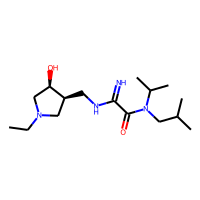
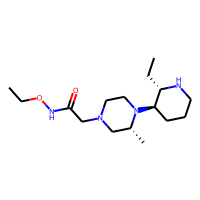
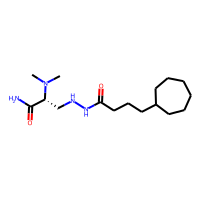
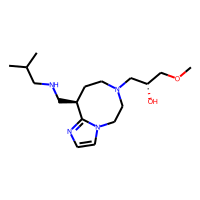
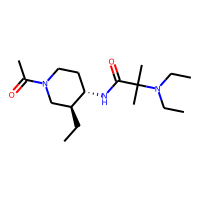
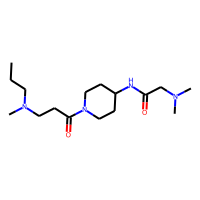
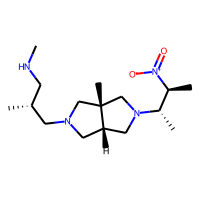
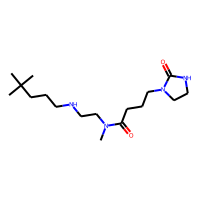
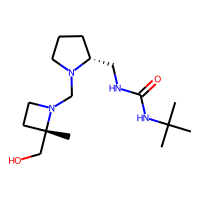
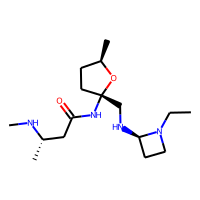
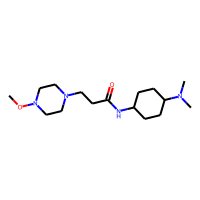

In [27]:
results, completion = check_model_output(model,['C16H32N4O2'],[1.0],batch_size=16,temperature=2)
df = completion_to_pandas(completion)
df

In [ ]:
from torchvision import datasets, models, transforms


In [ ]:
img_transform = transforms.Compose([
            transforms.ToTensor()
        ])

In [ ]:
smiles = 'CCOC(=O)c1ccc(O[C@H]2CCC[C@](C)(OCC)CC2)c(OCC2CCOCC2)c1'
